# HW 6
## 3. Histogram

In [136]:
!pip install pycuda

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [109]:
h_img = cv2.imread('dog.png', 0).astype(np.int32)
d_img = cuda.mem_alloc(h_img.nbytes)
cuda.memcpy_htod(d_img, h_img)
h_img.shape

(427, 640)

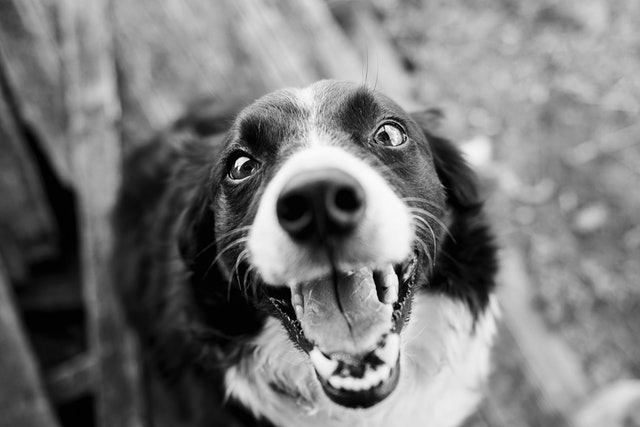

In [139]:
cv2_imshow(h_img)

In [163]:
rows = h_img.shape[1]
cols = h_img.shape[0]
block_size = 32
block = (block_size, block_size, 1)
grid = ((rows + block_size - 1) // block[0], (cols + block_size - 1) // block[1])

In [226]:
bin_count = 128

h_bins = np.linspace(0, 256, bin_count + 1, dtype=np.int32)
d_bins = cuda.mem_alloc(h_bins.nbytes)
cuda.memcpy_htod(d_bins, h_bins)
h_bins

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256],
      dtype=int32)

In [227]:
h_hist = np.zeros(bin_count, dtype=np.int32)
d_hist = cuda.mem_alloc(h_hist.nbytes)
cuda.memcpy_htod(d_hist, h_hist)
h_hist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [228]:
histogramModule = SourceModule("""
  __global__ void histogram(const int binCount, const int *bins, const int rows, const int cols, const int *img, int *hist)
  {
    unsigned int xIdx = threadIdx.x + blockIdx.x * blockDim.x;
    unsigned int yIdx = threadIdx.y + blockIdx.y * blockDim.y;
    if (yIdx < rows && xIdx < cols) {
        int val = img[yIdx * cols + xIdx];
        for (int i = 0; i < binCount; i++) {
            if (val >= bins[i] && val < bins[i + 1]) {
                atomicAdd(&(hist[i]), 1);
            }
        }
    }
  }
  """)

histogram = histogramModule.get_function('histogram')

In [229]:
histogram(
    np.int32(bin_count), 
    d_bins,
    np.int32(h_img.shape[0]), 
    np.int32(h_img.shape[1]), 
    d_img, 
    d_hist, 
    block=block,
    grid=grid
)
cuda.memcpy_dtoh(h_hist, d_hist)

In [230]:
cuda.memcpy_dtoh(h_hist, d_hist)
h_hist

array([ 824, 7349, 2597, 1508, 1918, 1561, 2563, 3410, 2908, 2392, 2801,
       2571, 2174, 1970, 2320, 1947, 2034, 2447, 2332, 1919, 1738, 1977,
       2055, 2073, 1685, 1701, 1938, 2077, 1872, 1865, 1860, 1770, 1855,
       1860, 1716, 1575, 1346, 1311, 1336, 1381, 1364, 1253, 1333, 1248,
       1247, 1251, 1202, 1303, 1359, 1522, 1598, 1713, 1820, 1757, 1637,
       1696, 1827, 1842, 1864, 2126, 2088, 2292, 2335, 2568, 2609, 2851,
       2864, 2756, 2800, 2862, 2908, 3207, 3217, 3384, 3201, 3383, 3548,
       3504, 3669, 3935, 4265, 4439, 4701, 4566, 4382, 4176, 4003, 4086,
       3977, 3900, 3537, 3576, 3515, 3475, 3311, 2940, 2665, 2308, 2024,
       1845, 1739, 1569, 1521, 1462, 1292, 1185, 1085,  904,  835,  848,
        990, 1253, 1322, 1338, 1144,  981, 1029,  826,  558,  655,  769,
        731,  723,  725,  536,   83,    7,    0], dtype=int32)

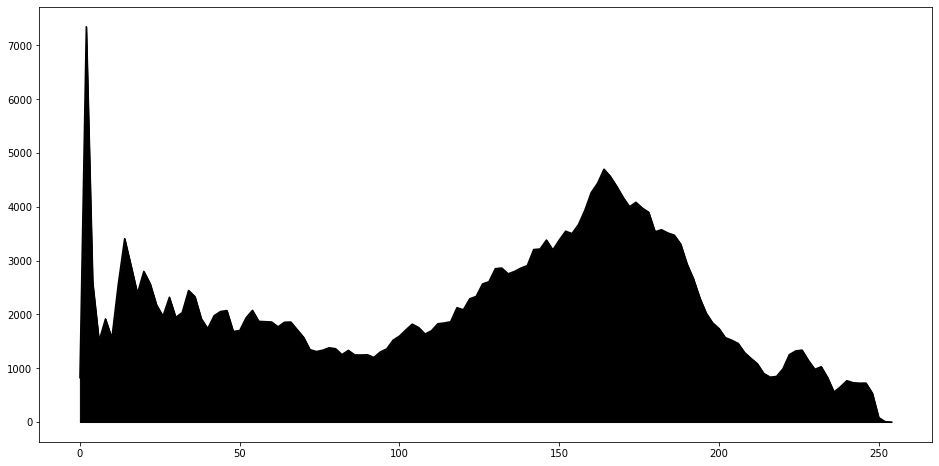

In [231]:
plt.figure(figsize=(16, 8))
plt.plot(h_bins[:-1], h_hist, c='black')
plt.fill_between(h_bins[:-1], h_hist, color='black')
